In [1]:
import math
import nltk
import unicodedata
import time
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as dt
from matplotlib.dates import DateFormatter

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras import models as md
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ravie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
company = "TSLA"

In [4]:
all_stocks = pd.read_csv("stock_yfinance_data.csv")
stock_df = all_stocks[all_stocks['Stock Name'] == company]
stock_df = stock_df.drop('Stock Name', axis=1)
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date
stock_df = stock_df.set_index("Date")
stock_df.dropna()

processed_df = pd.read_csv('tweet_processed_labeled.csv')
processed_df['Date'] = pd.to_datetime(processed_df['Date'])
processed_df['Date'] = processed_df['Date'].dt.date
daily_sentiments_df = processed_df.groupby([processed_df['Date']]).mean(numeric_only=True)

dataset_df = stock_df.copy()
dataset_df = dataset_df.join(daily_sentiments_df, how="left", on="Date")
dataset_df

,Open,High,Low,Close,Adj Close,Volume,Negative,Neutral,Positive,Compound
Date,,,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.081300,0.739611,0.179067,0.241496
2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.051798,0.811106,0.137106,0.198523
2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.057303,0.821563,0.121118,0.100760
2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.076352,0.796693,0.126989,0.112765
2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.054769,0.771756,0.173500,0.213876
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,275.329987,63748400,0.073233,0.792605,0.134128,0.124760
2022-09-26,271.829987,284.089996,270.309998,276.010010,276.010010,58076900,0.081292,0.765111,0.153556,0.130479
2022-09-27,283.839996,288.670013,277.510010,282.940002,282.940002,61925200,0.059835,0.796282,0.143882,0.178928


In [5]:
def SplitData(data, train_size, timestep):
    data_values = data.values
    training_data_len = math.ceil(len(data)* train_size)

    scaler = MinMaxScaler(feature_range=(0,1))
    if (len(data_values.shape) == 1):
        scaled_data = scaler.fit_transform(data_values.reshape(-1,1))
    else:
        scaled_data = scaler.fit_transform(data_values)
        scaled_index = scaler.fit_transform(data_values[:, 0:1].flatten().reshape(-1,1))

    train_data = scaled_data[0: training_data_len, :]
    test_data = scaled_data[training_data_len-timestep: , :]

    train_data_x = train_data[0: training_data_len, :]
    train_data_y = train_data[0: training_data_len, 0:1]

    x_train = []
    y_train = []

    for i in range(timestep, len(train_data_x)):
        x_train.append(train_data_x[i-timestep:i])
        y_train.append(train_data_y[i][0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

    test_data = scaled_data[training_data_len-timestep: , : ]
    x_test = []
    if (len(data_values.shape) == 1):
        y_test = data_values[training_data_len:]
    else:
        y_test = data_values[training_data_len: , 0]

    for i in range(timestep, len(test_data)):
        x_test.append(test_data[i-timestep:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

    return x_train, y_train, x_test, y_test, scaler

In [6]:
def TrainModel(x_data, y_data, epoch, neuron_units):

    regressor = Sequential()
    regressor.add(LSTM(units=neuron_units, return_sequences=True, input_shape=(x_data.shape[1], x_data.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units=neuron_units, return_sequences=False))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units=1, activation='linear'))

    regressor.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = regressor.fit(x_data, y_data, batch_size=1, epochs=epoch, verbose=0, validation_split=0.2)

    return regressor, history

In [7]:
def PlotTrainingMetrics(history):
    history_data = history.history
    
    loss_values = history_data['loss']
    val_loss_values = history_data['val_loss']
    mae_values = history_data['mae']
    val_mae_values = history_data['val_mae']
    rmse_values = np.sqrt(history_data['loss'])
    val_rmse_values = np.sqrt(history_data['val_loss'])
    epochs = range(1, len(loss_values) + 1)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 3, wspace=0)
    (ax1, ax2, ax3) = gs.subplots(sharey=True)
    fig.suptitle('Training and validation metrics')
    fig.supxlabel('epochs')

    ax1.plot(epochs, mae_values, color = 'blue', label='Training MAE')
    ax1.plot(epochs, val_mae_values, color='red', label='Validation MAE')
    ax1.set_title('MAE')
    ax1.set_xticks(epochs)
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax1.xaxis.grid(True, which='both', alpha=0.5)
    ax1.yaxis.grid(True, alpha=0.5)
    ax1.set_ylabel('value')
    ax1.legend()

    ax2.plot(epochs, loss_values, color = 'blue', label='Training loss')
    ax2.plot(epochs, val_loss_values, color='red', label='Validation loss')
    ax2.set_title('Loss (MSE)')
    ax2.set_xticks(epochs)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax2.xaxis.grid(True, which='both', alpha=0.5)
    ax2.yaxis.grid(True, alpha=0.5)
    ax2.legend()

    ax3.plot(epochs, rmse_values, color = 'blue', label='Training RMSE')
    ax3.plot(epochs, val_rmse_values, color='red', label='Validation RMSE')
    ax3.set_title('RMSE')
    ax3.set_xticks(epochs)
    ax3.xaxis.set_major_locator(ticker.MultipleLocator(len(loss_values)/5))
    ax3.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax3.xaxis.grid(True, which='both', alpha=0.5)
    ax3.yaxis.grid(True, alpha=0.5)
    ax3.legend()

In [6]:
def PlotPredictions(data, prediction):
    train_plot = data[:len(data)-len(prediction)]
    validation_plot = data[len(data)-len(prediction):].copy()
    validation_plot['Predictions'] = prediction

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Model and Predictions')
    ax.set_ylabel('Closing price (USD)')
    ax.set_xlabel('Date')
    ax.plot(train_plot)
    ax.plot(validation_plot[['Close', 'Predictions']])
    ax.xaxis.set_major_locator(dt.MonthLocator())
    ax.xaxis.set_minor_locator(dt.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(dt.DateFormatter('%b'))
    ax.grid(alpha=0.5, which='both')
    ax.legend(['Train', 'Validation', 'Predictions'])

In [9]:
single_data = dataset_df['Close']
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [8]:
model_mode = ['single', 'combined']

comparison_training_history = []
comparison_test_data = []

/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/traini

/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/ravie/.local/lib/python3.8/site-packages/keras/src/engine/traini

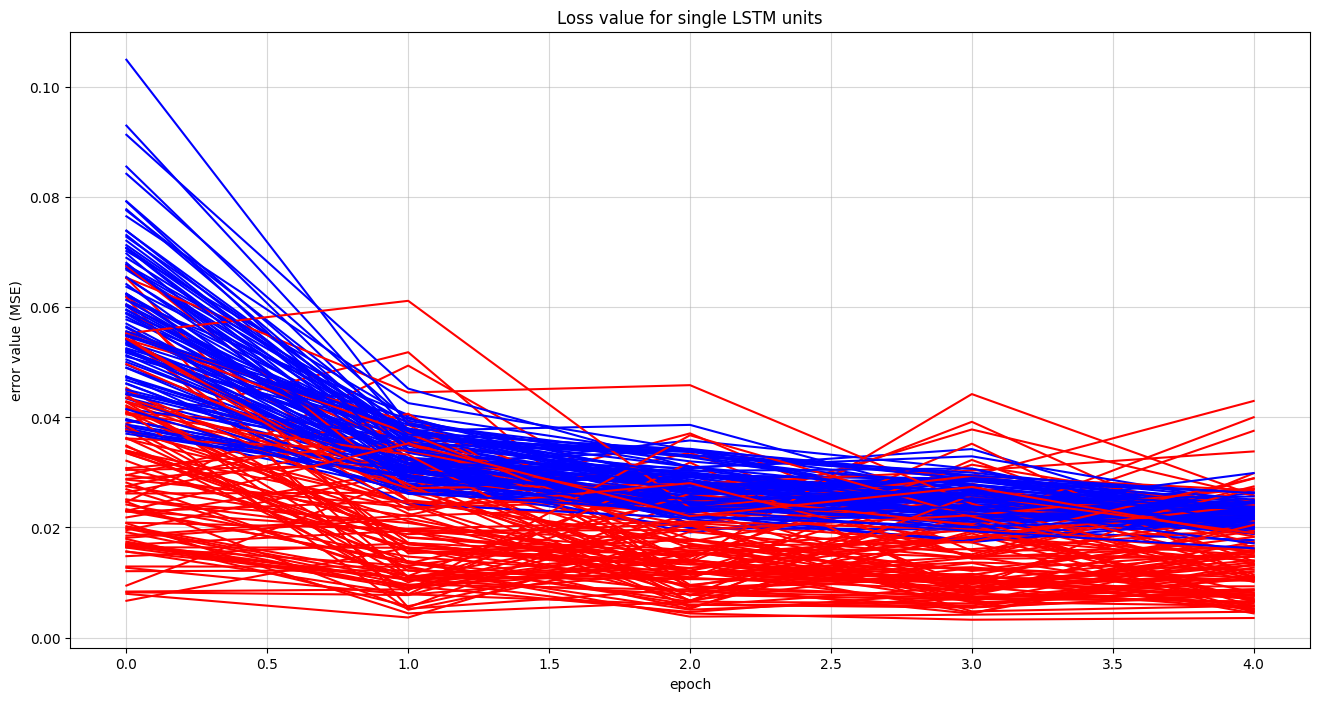

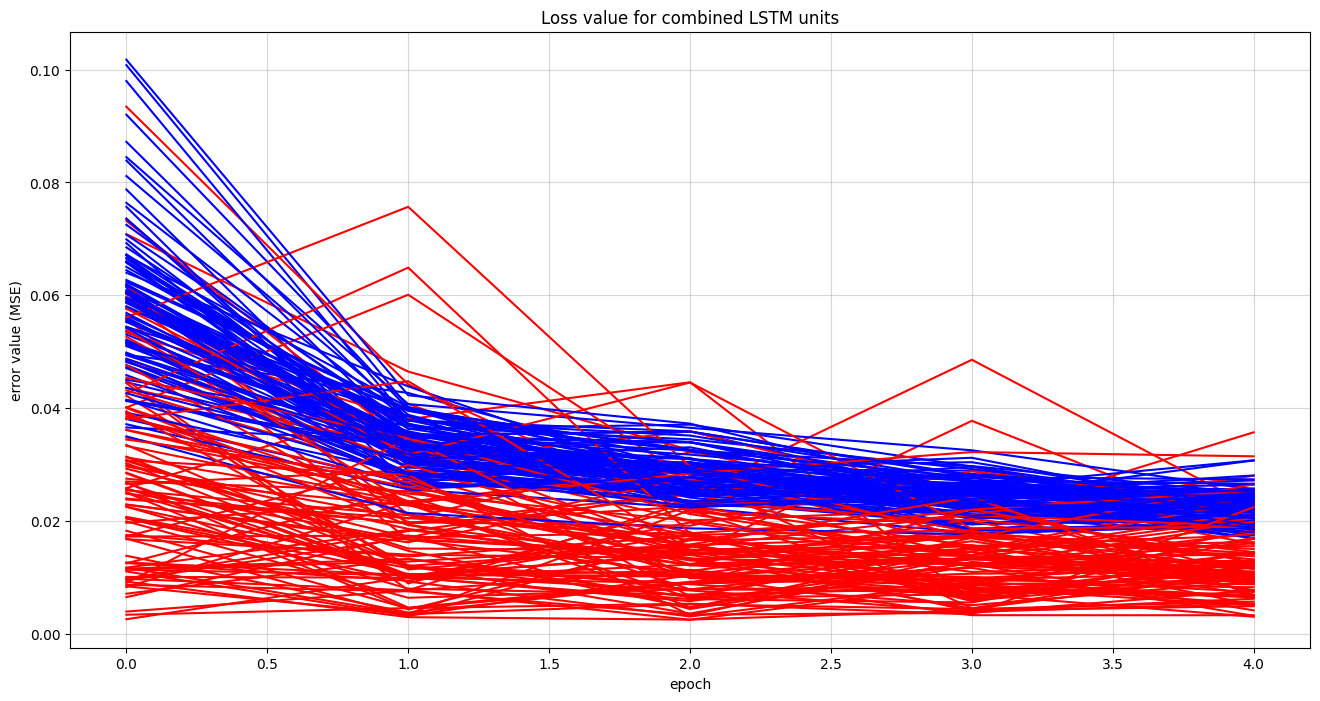

In [9]:
for i in range(len(model_mode)):
    
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.set_title('Loss value for ' + str(model_mode[i]) + ' LSTM units')
    ax.set_xlabel('epoch')
    ax.set_ylabel('error value (MSE)')
    ax.xaxis.grid(True, which='both', alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)

    for k in range(100):

        x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

        start_time = time.time()
        sentimentModel, history = TrainModel(x_train, y_train, 5, 16)
        end_time = time.time()
        training_time = end_time - start_time

        sentimentModel.save('compare_data/saved_model/'+ str(model_mode[i]) + '_' + str(k) +'.h5')

        history_data = history.history
    
        loss_values = history_data['loss']
        val_loss_values = history_data['val_loss']

        comparison_training_history.append([model_mode[i], k, history_data['loss'], history_data['val_loss'], history_data['mae'], history_data['val_mae'], training_time])


        predictions = sentimentModel.predict(x_test, verbose=0)
        predictions = scaler.inverse_transform(predictions)

        mae = np.mean(np.abs(predictions - y_test))
        mse = np.mean((predictions - y_test)**2)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100

        comparison_test_data.append([model_mode[i], k, mae, mse, rmse, mape, training_time])


        ax.plot(loss_values, color = 'blue')
        ax.plot(val_loss_values, color='red')

    plt.savefig('compare_data/'+ str(model_mode[i]) +'model', facecolor=(1, 1, 1))

In [10]:
training_comparison = pd.DataFrame(comparison_training_history, columns=['#mode', '#try', 'loss', 'val_loss', 'mae', 'val_mae', 'train_time'])
training_comparison.to_csv('compare_data/finetuning_training_data.csv', index=False)

In [11]:
testing_comparison = pd.DataFrame(comparison_test_data, columns=['#mode', '#try', 'MAE', 'MSE', 'RMSE', 'MAPE', 'train_time'])
testing_comparison.to_csv('compare_data/finetuning_testing_data.csv', index=False)

## compare training data

In [8]:
model_mode = ['single', 'combined']

In [9]:
compare_training = pd.read_csv('compare_data/finetuning_training_data.csv')

In [ ]:
for i in range(len(model_mode)):

    fig, ax = plt.figure(figsize=(12, 6))
    
    train_loss_data = pd.DataFrame()
    train_val_loss_data = pd.DataFrame()

    tf = compare_training.iloc[i*100 : i*100 + 100]
    tf.loc[:, 'loss'] = tf.loc[:, 'loss'].apply(literal_eval)
    tf.loc[:, 'val_loss'] = tf.loc[:, 'val_loss'].apply(literal_eval)

    for k in range(100):
        train_loss_data[str(k)] = tf.loc[i*100 + k, 'loss']
        train_val_loss_data[str(k)] = tf.loc[i*100 + k, 'val_loss']

    ax.plot(range(1, 6), train_loss_data, color = 'blue', linewidth=0.7)
    ax.plot(range(1, 6), train_val_loss_data, color='red', linewidth=0.7)
    ax.set_title(str(model_mode[i]) + ' model')
    ax.set_ylabel('nilai error (MSE)')
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, steps=[1,2,5,10]))
    ax.xaxis.grid(True, alpha=0.5)
    ax.yaxis.grid(True, alpha=0.5)
    ax.set_ylim(0.0, 0.12)

    plt.savefig('compare_data/error_plots/'+ str(model_mode[i]) +'.png', facecolor=(1, 1, 1), bbox_inches='tight')

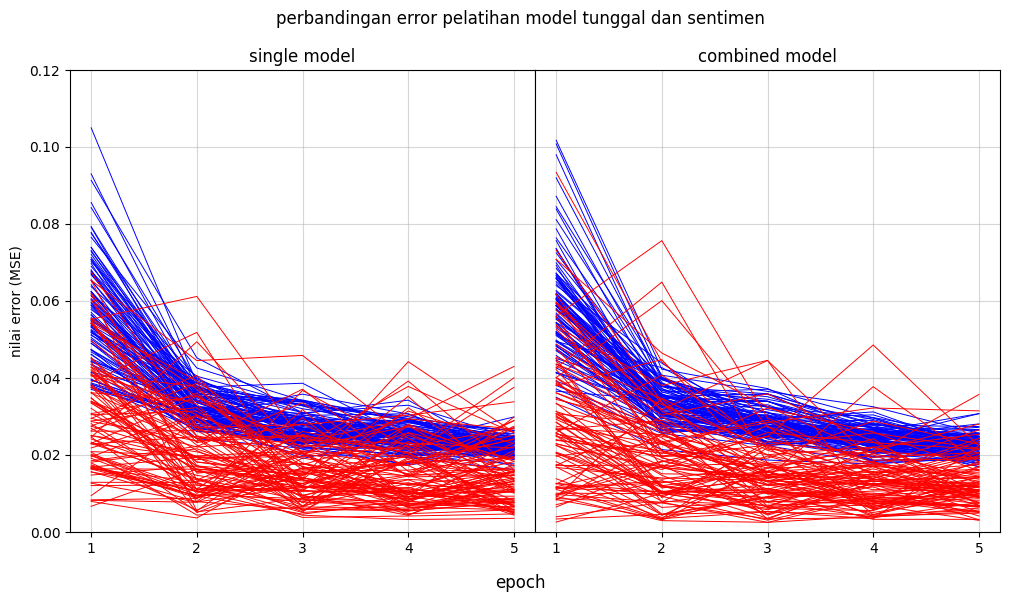

In [10]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('perbandingan error pelatihan model tunggal dan sentimen')
fig.supxlabel('epoch')
gs = fig.add_gridspec(1, 2, wspace=0)
ax = gs.subplots(sharey=True)

for i in range(len(model_mode)):
    
    train_loss_data = pd.DataFrame()
    train_val_loss_data = pd.DataFrame()

    tf = compare_training.iloc[i*100 : i*100 + 100]
    tf.loc[:, 'loss'] = tf.loc[:, 'loss'].apply(literal_eval)
    tf.loc[:, 'val_loss'] = tf.loc[:, 'val_loss'].apply(literal_eval)

    for k in range(100):
        train_loss_data[str(k)] = tf.loc[i*100 + k, 'loss']
        train_val_loss_data[str(k)] = tf.loc[i*100 + k, 'val_loss']

    ax[i].plot(range(1, 6), train_loss_data, color = 'blue', linewidth=0.7)
    ax[i].plot(range(1, 6), train_val_loss_data, color='red', linewidth=0.7)
    ax[i].set_title(str(model_mode[i]) + ' model')
    ax[i].set_ylabel('nilai error (MSE)')
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True, steps=[1,2,5,10]))
    ax[i].xaxis.grid(True, alpha=0.5)
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_ylim(0.0, 0.12)

    if i > 0:
        ax[i].tick_params(axis='y', which='both', left=False, right=False)

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig('compare_data/error_plots/'+ str(model_mode[i]) +'.png', facecolor=(1, 1, 1), bbox_inches='tight')

## compare testing data

In [18]:
model_mode = ['single', 'combined']

In [19]:
compare_testing = pd.read_csv('compare_data/finetuning_testing_data.csv')

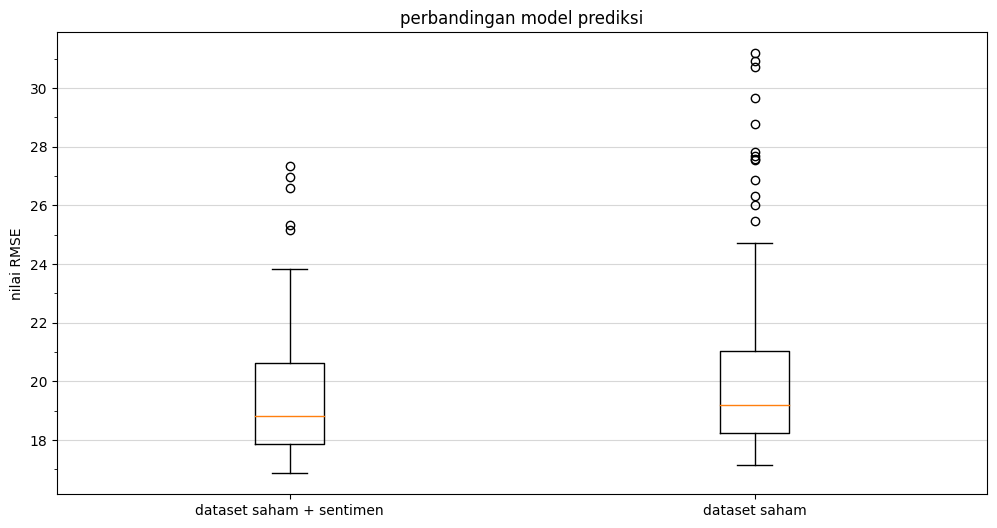

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))

boxplot_data = compare_testing.pivot(index='#try', columns='#mode', values='RMSE')

ax.boxplot(boxplot_data)
ax.set_xticklabels(['dataset saham + sentimen', 'dataset saham'])
ax.set_title('perbandingan model prediksi')
ax.set_ylabel('nilai RMSE')
ax.yaxis.grid(True, alpha=0.5)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.savefig('compare_data/error_plots/boxplot_full.png', facecolor=(1, 1, 1), bbox_inches='tight')

In [30]:
compare_testing.iloc[100:200].describe()

,#try,MAE,MSE,RMSE,MAPE,train_time
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,49.500000,15.752150,387.152831,19.549913,5.489413,20.175238
std,29.011492,2.089053,95.491572,2.236915,0.748341,1.965943
min,0.000000,13.696827,284.548745,16.868573,4.725376,18.205595
25%,24.750000,14.254101,319.047689,17.861894,4.967582,18.827878
50%,49.500000,14.947122,354.194594,18.820026,5.193472,19.432217
75%,74.250000,16.676351,426.003022,20.639840,5.852960,20.269047
max,99.000000,23.674626,746.858060,27.328704,8.329132,25.042107


In [49]:
single_data = dataset_df['Close']
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

In [26]:
singleModel = md.load_model('saved_model/single-features.h5')

In [27]:
predictions_single = singleModel.predict(x_test)
predictions_single = scaler.inverse_transform(predictions_single)

mae = np.mean(np.abs(predictions_single - y_test))
mse = np.mean((predictions_single - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions_single)/y_test)) * 100
mae, mse, rmse, mape

2/2 [==============================] - 2s 36ms/step


(16.96082995605469, 437.38626997106076, 20.913781818959976, 5.962604849390294)

In [50]:
single_data_predicted = pd.DataFrame(single_data[len(single_data)-50:])

In [52]:
single_data_predicted

,Close
Date,
2022-07-21,271.706665
2022-07-22,272.243347
2022-07-25,268.433319
2022-07-26,258.859985
2022-07-27,274.820007
2022-07-28,280.899994
2022-07-29,297.149994
2022-08-01,297.276672
2022-08-02,300.586670


In [53]:
single_data_predicted['Predicted'] = predictions_single
single_data_predicted

,Close,Predicted
Date,,
2022-07-21,271.706665,257.101074
2022-07-22,272.243347,263.904877
2022-07-25,268.433319,271.992340
2022-07-26,258.859985,278.372528
2022-07-27,274.820007,280.571777
2022-07-28,280.899994,283.424164
2022-07-29,297.149994,287.100342
2022-08-01,297.276672,293.783081
2022-08-02,300.586670,300.491974


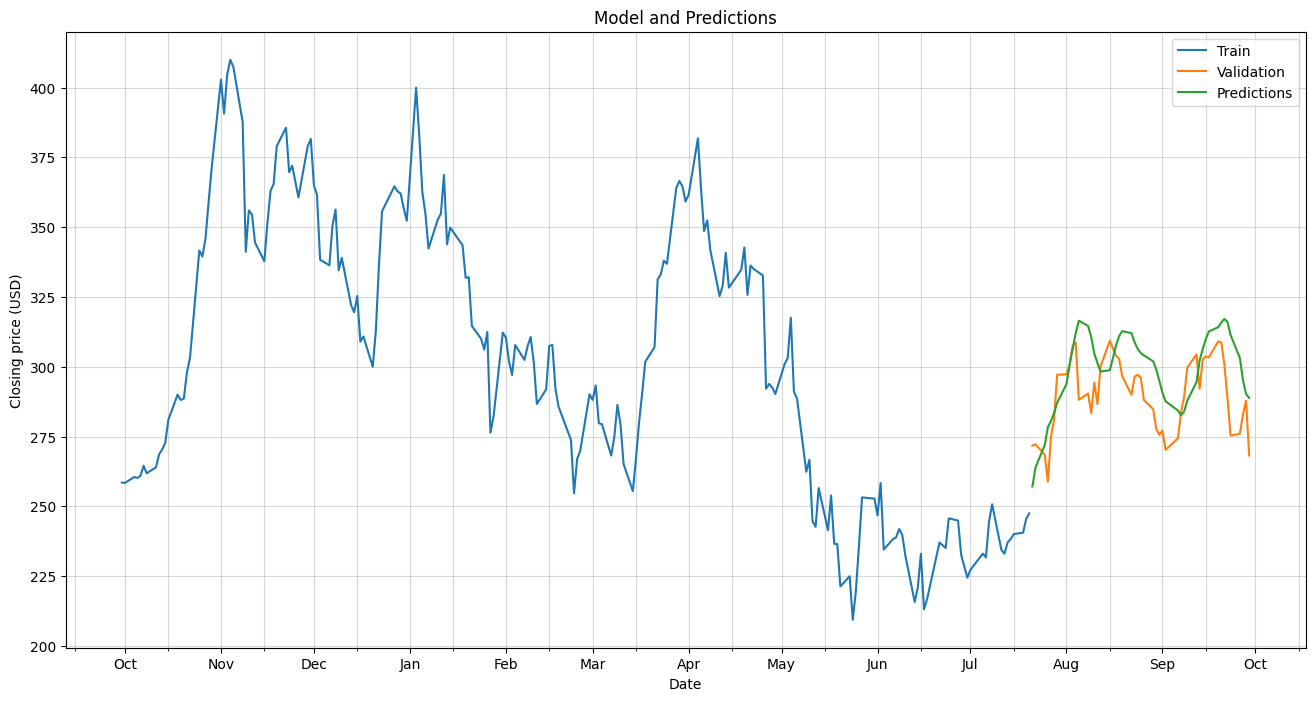

In [28]:
PlotPredictions(dataset_df.filter(['Close']), predictions_single)

In [9]:
combined_data = dataset_df[['Close', 'Compound']].copy()

train_portion = 0.8
timestep = 60

x_train, y_train, x_test, y_test, scaler = SplitData(combined_data, train_portion, timestep)

In [7]:
sentimentModel = md.load_model('saved_model/multi-features.h5')

In [10]:
predictions = sentimentModel.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 3s 42ms/step


In [11]:
mae = np.mean(np.abs(predictions - y_test))
mse = np.mean((predictions - y_test)**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions)/y_test)) * 100
mae, mse, rmse, mape

(15.034818408203124,
 356.69338249142396,
 18.886327925020893,
 5.2093261004329925)

In [12]:
combined_data_predicted = pd.DataFrame(combined_data[len(combined_data)-50:])

In [13]:
combined_data_predicted['Predicted'] = predictions

In [14]:
combined_data_predicted['Difference'] = combined_data_predicted['Close'] - combined_data_predicted['Predicted']

In [15]:
combined_data_predicted['% Diff'] = ((combined_data_predicted['Close'] - combined_data_predicted['Predicted'])/combined_data_predicted['Close'])*100

In [16]:
combined_data_predicted['Volume'] = dataset_df.iloc[len(combined_data)-50:, 5:6]

In [17]:
combined_data_predicted['Daily Lag'] = combined_data_predicted['Close'].shift(1)

In [18]:
combined_data_predicted['Predicted Daily Lag'] = combined_data_predicted['Predicted'].shift(1)

In [19]:
combined_data_predicted['Daily Returns'] = (combined_data_predicted['Daily Lag']/combined_data_predicted['Close']) -1

In [20]:
combined_data_predicted['Predicted Daily Returns'] = (combined_data_predicted['Predicted Daily Lag']/combined_data_predicted['Predicted']) -1

In [21]:
combined_data_predicted['Predicted Daily Return Percentage Diff'] = ((combined_data_predicted['Daily Returns'] - combined_data_predicted['Predicted Daily Returns'])/combined_data_predicted['Daily Returns'])*100

In [22]:
combined_data_predicted['Adj Close'] = dataset_df.iloc[len(combined_data)-50:, 4:5]

In [23]:
ma_day = [3,5,10]

for ma in ma_day:
    column_name = "MA-%s" %(str(ma))
    combined_data_predicted[column_name] = combined_data_predicted['Adj Close'].rolling(window=ma,center=False).mean()

In [29]:
combined_data_predicted.iloc[0, 7] = 247.5

In [30]:
combined_data_predicted

,Close,Compound,Predicted,Difference,% Diff,Volume,Daily Lag,Predicted Daily Lag,Daily Returns,Predicted Daily Returns,Predicted Daily Return Percentage Diff,Adj Close,MA-3,MA-5,MA-10
Date,,,,,,,,,,,,,,,
2022-07-21,271.706665,0.120248,247.286774,24.419891,8.987594,142032300,NaN,247.500000,NaN,NaN,NaN,271.706665,NaN,NaN,NaN
2022-07-22,272.243347,0.194502,253.763611,18.479736,6.787948,103472700,271.706665,247.286774,-0.001971,-0.025523,-1194.714490,272.243347,NaN,NaN,NaN
2022-07-25,268.433319,0.222251,262.671265,5.762054,2.146550,64073400,272.243347,253.763611,0.014194,-0.033912,338.923371,268.433319,270.794444,NaN,NaN
2022-07-26,258.859985,0.085758,270.373962,-11.513977,-4.447956,66820800,268.433319,262.671265,0.036983,-0.028489,177.033519,258.859985,266.512217,NaN,NaN
2022-07-27,274.820007,0.133076,271.849182,2.970825,1.081008,88110000,258.859985,270.373962,-0.058074,-0.005427,90.655813,274.820007,267.371104,269.212665,NaN
2022-07-28,280.899994,0.258980,274.578033,6.321960,2.250609,84723000,274.820007,271.849182,-0.021645,-0.009938,54.084026,280.899994,271.526662,271.051331,NaN
2022-07-29,297.149994,0.187413,280.131927,17.018066,5.727096,95313000,280.899994,274.578033,-0.054686,-0.019826,63.745881,297.149994,284.289998,276.032660,NaN
2022-08-01,297.276672,0.151538,287.278198,9.998474,3.363356,117042900,297.149994,280.131927,-0.000426,-0.024876,-5737.600790,297.276672,291.775553,281.801331,NaN
2022-08-02,300.586670,0.244551,293.245972,7.340698,2.442124,95577600,297.276672,287.278198,-0.011012,-0.020351,-84.808760,300.586670,298.337779,290.146667,NaN


In [76]:
combined_data_predicted.describe()

,Close,Compound,Predicted,Difference,% Diff,Volume,Daily Lag,Predicted Daily Lag,Daily Returns,Predicted Daily Returns,Predicted Daily Return Percentage Diff,Adj Close,MA-3,MA-5,MA-10
count,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,49.000000,49.000000,49.000000,49.000000,49.000000,50.000000,48.000000,46.000000,41.000000
mean,290.086001,0.156929,288.270691,1.815274,0.556977,7.142706e+07,290.532450,288.480713,0.000682,-0.002279,-2.779697,290.086001,290.784816,291.495900,292.659172
std,13.139191,0.049526,13.710289,11.662673,4.064184,2.069288e+07,12.886486,13.770884,0.029302,0.014645,893.378447,13.139191,11.618880,9.986150,5.996463
min,258.859985,0.057744,247.286774,-22.379059,-8.128086,4.186470e+07,258.859985,247.286774,-0.058074,-0.033912,-5737.600790,258.859985,266.512217,269.212665,281.704004
25%,278.500008,0.125108,279.794006,-5.912125,-2.165910,5.584740e+07,280.899994,280.048889,-0.019221,-0.012570,54.134215,278.500008,281.684168,283.705003,287.958002
50%,290.168335,0.157218,291.626999,3.052460,1.048241,6.443445e+07,290.423340,291.657166,-0.001971,-0.001050,94.539548,290.168335,293.712224,293.681339,294.822668
75%,300.746658,0.179971,298.194328,8.214935,2.739883,8.586420e+07,300.799988,298.243652,0.023294,0.009596,158.006268,300.746658,299.552498,299.846497,297.367999
max,309.320007,0.296843,308.795135,25.029449,8.987594,1.420323e+08,309.320007,308.795135,0.073077,0.024390,1089.962990,309.320007,307.050008,305.502002,301.380002


In [75]:
combined_data_predicted.to_csv('final_analysis.csv', index=False)

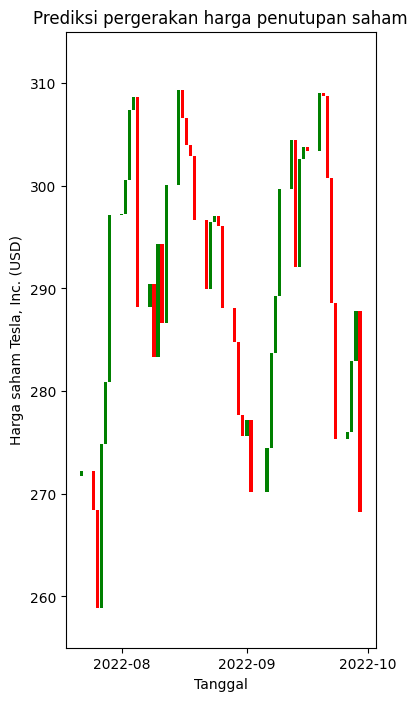

In [50]:
fig, ax = plt.subplots(figsize=(4,8))

up = combined_data_predicted[combined_data_predicted['Close'] >= combined_data_predicted['Daily Lag']]
down = combined_data_predicted[combined_data_predicted['Close'] < combined_data_predicted['Daily Lag']]

ax.bar(up.index, up['Close'] - up['Daily Lag'], width=0.8, bottom=up['Daily Lag'], color='green')
ax.bar(down.index, down['Close'] - down['Daily Lag'], width=0.8, bottom=down['Daily Lag'], color='red')
ax.set_ylim(255, 315)
ax.xaxis.set_major_locator(dt.MonthLocator())
ax.set_title('Prediksi pergerakan harga penutupan saham')
ax.set_ylabel('Harga saham Tesla, Inc. (USD)')
ax.set_xlabel('Tanggal')

fig.savefig('barplot.png', facecolor=(1, 1, 1), bbox_inches='tight')

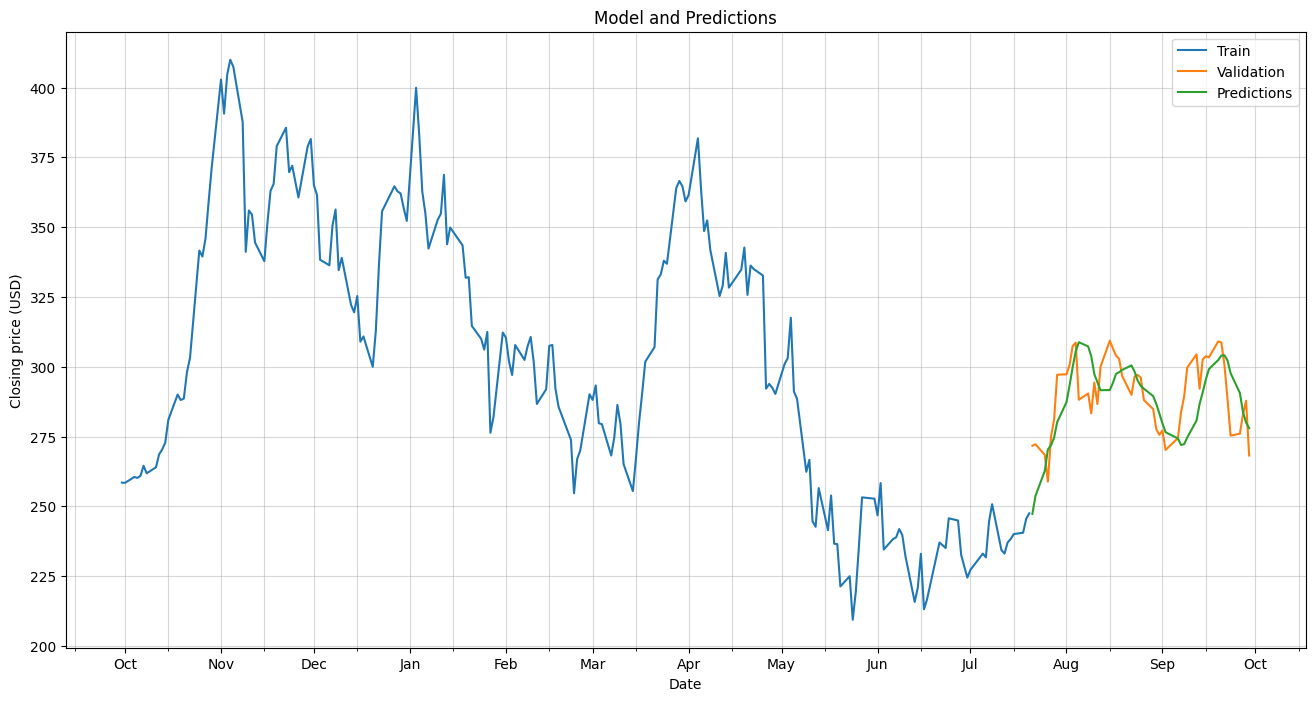

In [59]:
PlotPredictions(dataset_df.filter(['Close']), predictions)